# Assignment 6
- by Martim Silva 51304 and Alexandre Sobreira 59451

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
import pathlib
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Data

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 1s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

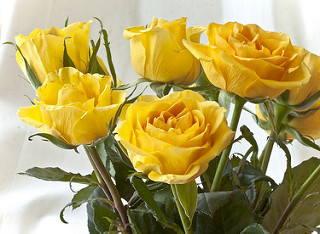

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

## Pre Process

### Create a dataset

Parameters for the loader:

It's good practice to use a validation split when developing the model. We will 80% of the images for training and 20% for validation.

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Class names in the `class_names` attribute on these datasets. 

In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

Here are the first nine images from the training dataset:

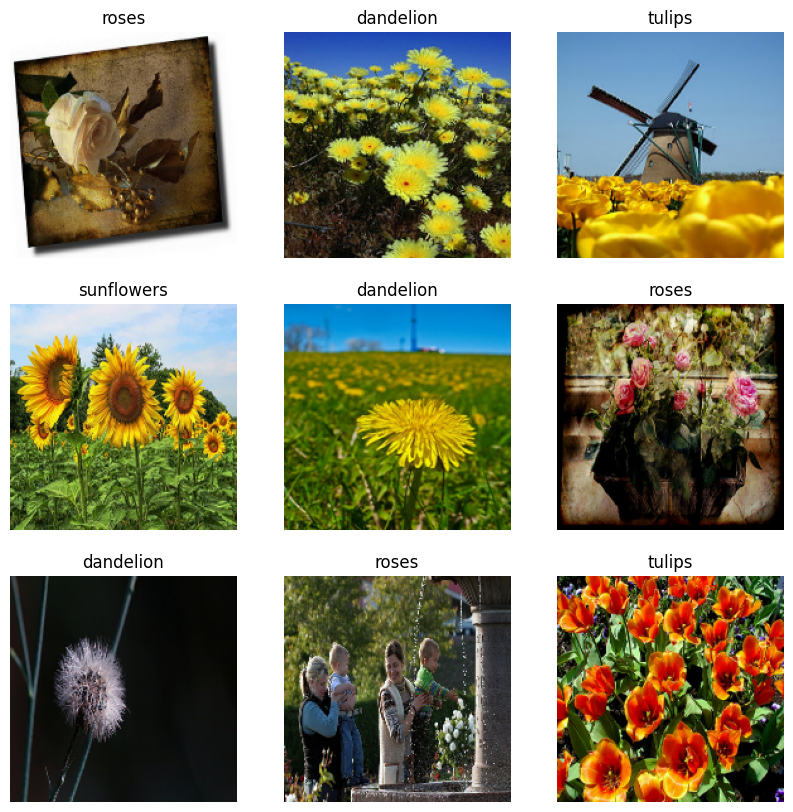

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


### Datase configuration for performance

The buffered prefetching is importing so we can yield data from disk without having I/O become blocking. These are two important methods that should be used when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general it should be seeked to make the input values small.

Here, we will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

We will include the layer for standardization inside the model definition, which can simplify deployment.

## Base Model


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train

Train the model for 10 epochs with the Keras `Model.fit` method:

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 20s 55ms/step - loss: 1.3883 - accuracy: 0.4121 - val_loss: 1.1466 - val_accuracy: 0.5150
Epoch 2/10
92/92 [==============================] - 2s 20ms/step - loss: 1.0403 - accuracy: 0.5790 - val_loss: 1.0095 - val_accuracy: 0.6076
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.8569 - accuracy: 0.6659 - val_loss: 0.8832 - val_accuracy: 0.6594
Epoch 4/10
92/92 [==============================] - 2s 19ms/step - loss: 0.6536 - accuracy: 0.7582 - val_loss: 0.9205 - val_accuracy: 0.6662
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.4634 - accuracy: 0.8314 - val_loss: 1.0555 - val_accuracy: 0.6417
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.2779 - accuracy: 0.9077 - val_loss: 1.2455 - val_accuracy: 0.6322
Epoch 7/10
92/92 [==============================] - 2s 21ms/step - loss: 0.1612 - accuracy: 0.9510 - val_loss: 1.4938 - val_accuracy: 0.6431
Epoch 8/10
9

### Training results viz


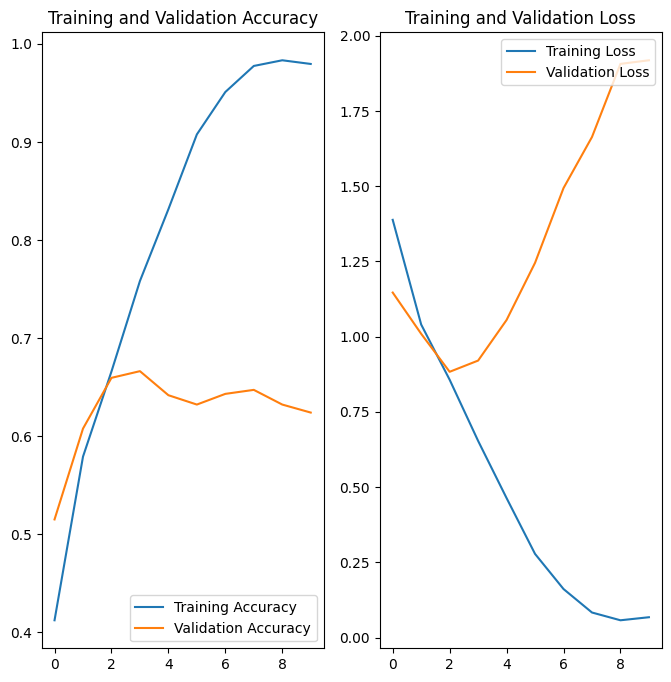

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

# Problem 1
Create 4 different models, one at a time, by modifying the reference model in the following
manner:

## i) 
Using the mean squared error as a loss function.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 4s 24ms/step - loss: 1.7513 - accuracy: 0.1887 - val_loss: 1.5016 - val_accuracy: 0.1894
Epoch 2/10
92/92 [==============================] - 2s 21ms/step - loss: 1.2991 - accuracy: 0.1887 - val_loss: 1.1871 - val_accuracy: 0.2779
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 1.1257 - accuracy: 0.2061 - val_loss: 1.1288 - val_accuracy: 0.2221
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.9350 - accuracy: 0.1778 - val_loss: 1.1262 - val_accuracy: 0.2738
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.7560 - accuracy: 0.1696 - val_loss: 1.0875 - val_accuracy: 0.1785
Epoch 6/10
92/92 [==============================] - 2s 22ms/step - loss: 0.7384 - accuracy: 0.1717 - val_loss: 1.1513 - val_accuracy: 0.2384
Epoch 7/10
92/92 [==============================] - 2s 20ms/step - loss: 0.6120 - accuracy: 0.1792 - val_loss: 1.2029 - val_accuracy: 0.2139
Epoch 8/10
92

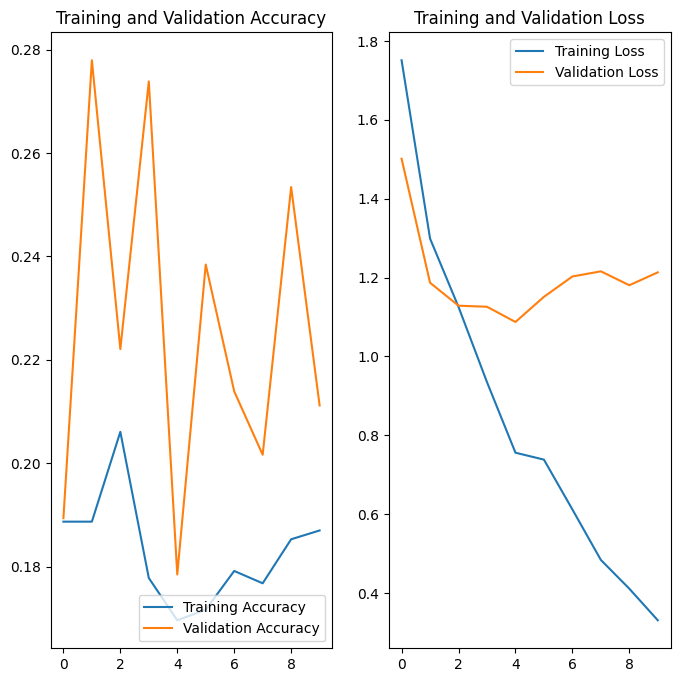

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## ii) 
Using a dropout probability of 40%.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.4),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 4s 24ms/step - loss: 1.3504 - accuracy: 0.4281 - val_loss: 1.0637 - val_accuracy: 0.5627
Epoch 2/10
92/92 [==============================] - 2s 21ms/step - loss: 1.0223 - accuracy: 0.5933 - val_loss: 1.0079 - val_accuracy: 0.5817
Epoch 3/10
92/92 [==============================] - 2s 22ms/step - loss: 0.8113 - accuracy: 0.6853 - val_loss: 0.9092 - val_accuracy: 0.6267
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.6431 - accuracy: 0.7517 - val_loss: 0.8485 - val_accuracy: 0.6880
Epoch 5/10
92/92 [==============================] - 2s 22ms/step - loss: 0.4505 - accuracy: 0.8396 - val_loss: 0.8893 - val_accuracy: 0.6785
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.3075 - accuracy: 0.8992 - val_loss: 0.9935 - val_accuracy: 0.6730
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 0.1865 - accuracy: 0.9387 - val_loss: 1.1918 - val_accuracy: 0.6649
Epoch 8/10
92

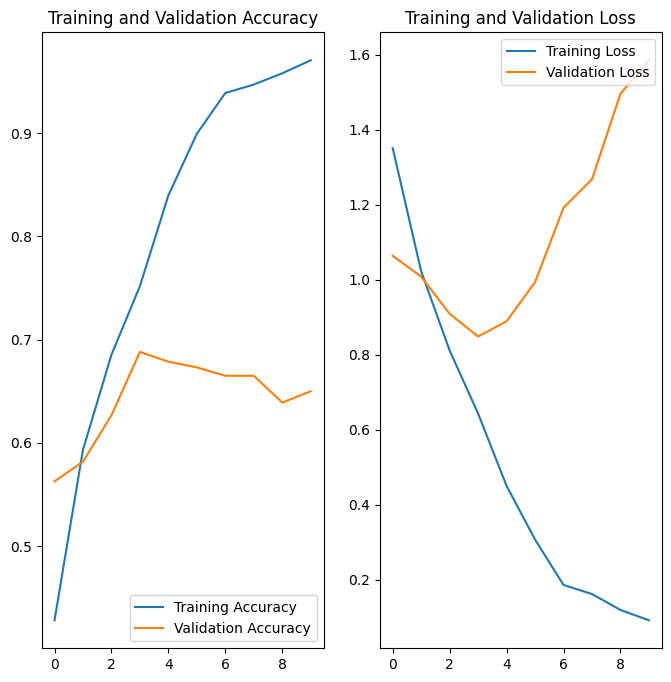

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## iii) 
Using a batch size of 8.

In [ ]:
batch_size = 8
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
367/367 [==============================] - 11s 12ms/step - loss: 1.2413 - accuracy: 0.4745 - val_loss: 1.0061 - val_accuracy: 0.5872
Epoch 2/10
367/367 [==============================] - 3s 7ms/step - loss: 0.9408 - accuracy: 0.6308 - val_loss: 0.9457 - val_accuracy: 0.6158
Epoch 3/10
367/367 [==============================] - 3s 8ms/step - loss: 0.6930 - accuracy: 0.7405 - val_loss: 0.8606 - val_accuracy: 0.6526
Epoch 4/10
367/367 [==============================] - 3s 7ms/step - loss: 0.4383 - accuracy: 0.8379 - val_loss: 0.9683 - val_accuracy: 0.6431
Epoch 5/10
367/367 [==============================] - 3s 8ms/step - loss: 0.2212 - accuracy: 0.9285 - val_loss: 1.1276 - val_accuracy: 0.6757
Epoch 6/10
367/367 [==============================] - 3s 8ms/step - loss: 0.1045 - accuracy: 0.9670 - val_loss: 1.2946 - val_accuracy: 0.6567
Epoch 7/10
367/367 [==============================] - 3s 7ms/step - loss: 0.0957 - accuracy: 0.9714 - val_loss: 1.5148 - val_accuracy: 0.6594
Epoc

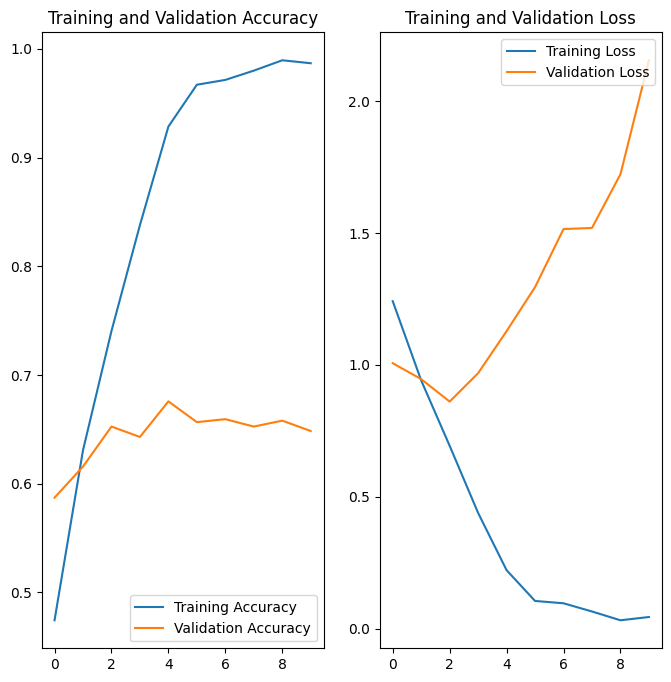

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## iv) 
Using batch normalization.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 11s 34ms/step - loss: 1.3128 - accuracy: 0.4390 - val_loss: 1.0787 - val_accuracy: 0.5640
Epoch 2/10
92/92 [==============================] - 2s 25ms/step - loss: 0.9602 - accuracy: 0.6223 - val_loss: 0.9476 - val_accuracy: 0.6458
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.7647 - accuracy: 0.7098 - val_loss: 0.8942 - val_accuracy: 0.6444
Epoch 4/10
92/92 [==============================] - 2s 20ms/step - loss: 0.5732 - accuracy: 0.7834 - val_loss: 0.8435 - val_accuracy: 0.6771
Epoch 5/10
92/92 [==============================] - 2s 19ms/step - loss: 0.3616 - accuracy: 0.8723 - val_loss: 1.0539 - val_accuracy: 0.6362
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.2204 - accuracy: 0.9213 - val_loss: 1.1778 - val_accuracy: 0.6512
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 0.1375 - accuracy: 0.9571 - val_loss: 1.1365 - val_accuracy: 0.6635
Epoch 8/10
9

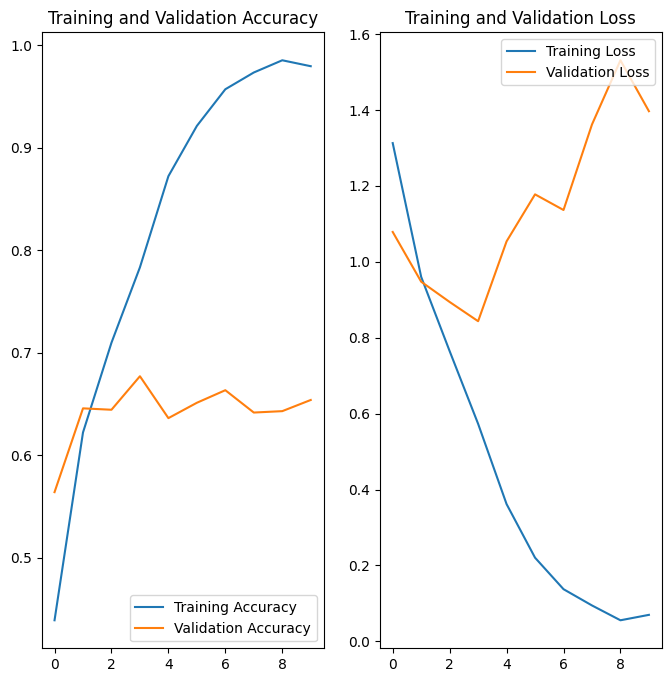

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## v) 
Combine modifications ii, iii and iv.

In [ ]:
batch_size = 8
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 90, 90, 32)      

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
367/367 [==============================] - 14s 16ms/step - loss: 2.2185 - accuracy: 0.4009 - val_loss: 2.8507 - val_accuracy: 0.3106
Epoch 2/10
367/367 [==============================] - 5s 13ms/step - loss: 1.3909 - accuracy: 0.4441 - val_loss: 1.3607 - val_accuracy: 0.4905
Epoch 3/10
367/367 [==============================] - 5s 13ms/step - loss: 1.1293 - accuracy: 0.5657 - val_loss: 1.1679 - val_accuracy: 0.5599
Epoch 4/10
367/367 [==============================] - 6s 16ms/step - loss: 0.9169 - accuracy: 0.6362 - val_loss: 1.2928 - val_accuracy: 0.5736
Epoch 5/10
367/367 [==============================] - 5s 14ms/step - loss: 0.7144 - accuracy: 0.7132 - val_loss: 1.2629 - val_accuracy: 0.5845
Epoch 6/10
367/367 [==============================] - 6s 15ms/step - loss: 0.6037 - accuracy: 0.7674 - val_loss: 1.2266 - val_accuracy: 0.5981
Epoch 7/10
367/367 [==============================] - 5s 13ms/step - loss: 0.4659 - accuracy: 0.8134 - val_loss: 1.5005 - val_accuracy: 0.580

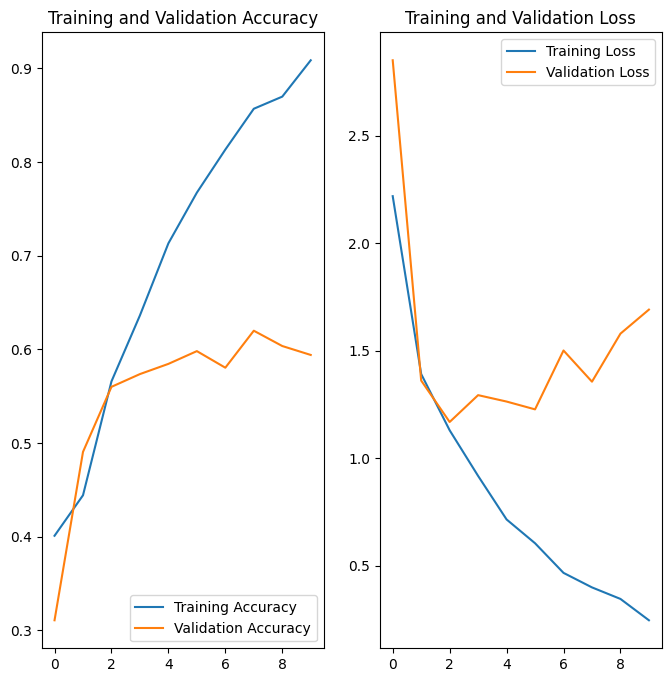

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Problem 2
Implement an autoencoder to learn to encode images from the dataset given in the image classification
tutorial, based on the reference model used in the previous exercise.

## Pre Processing

In [134]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [135]:
batch_size = 32
img_height = 180
img_width = 180

In [136]:
# set training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=1-(3500/3670),
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 3500 files for training.


In [137]:
# set validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=1-(3500/3670),
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 170 files for validation.


In [138]:
# performance configuration
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [139]:
# normalization
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [140]:
# remove layers
train_ds = np.concatenate([x for x, y in train_ds], axis=0)
val_ds = np.concatenate([x for x, y in val_ds], axis=0)

# convert to tensor
train_ds = tf.convert_to_tensor(train_ds)
val_ds = tf.convert_to_tensor(val_ds)

## a) 
Train an autoencoder on 3500 images from the image classification dataset, leaving 170 aside for validation.

#### Base Model

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Autoenconder Tutorial 

In [60]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

### New Autoencoder

In [143]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Input(shape = (180, 180, 3)),
      layers.Conv2D(16, 3, activation='relu', padding='same'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, activation='relu', padding='same'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, activation='relu', padding='same'),
      layers.MaxPooling2D(),
      layers.Dropout(.2),
      layers.Flatten(),
      layers.Dense(latent_dim)
      ])

    self.decoder = tf.keras.Sequential([
      layers.Dense(45*45*64, activation = "relu"),
      layers.Reshape((45, 45, 64)),
      layers.Conv2D(32, 3, activation='relu', padding='same'),
      layers.UpSampling2D(),
      layers.Conv2D(16, 3, activation='relu', padding='same'),
      layers.UpSampling2D(),
      layers.Conv2D(3, 3, activation='sigmoid', padding='same'),
      ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)


In [144]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [145]:
autoencoder.fit(train_ds, train_ds,
                epochs=10,
                shuffle=True,
                batch_size = batch_size,
                validation_data=(val_ds, val_ds))

Epoch 1/10
110/110 [==============================] - 14s 68ms/step - loss: 0.0645 - val_loss: 0.0473
Epoch 2/10
110/110 [==============================] - 7s 60ms/step - loss: 0.0427 - val_loss: 0.0385
Epoch 3/10
110/110 [==============================] - 7s 59ms/step - loss: 0.0363 - val_loss: 0.0349
Epoch 4/10
110/110 [==============================] - 7s 60ms/step - loss: 0.0324 - val_loss: 0.0326
Epoch 5/10
110/110 [==============================] - 7s 60ms/step - loss: 0.0291 - val_loss: 0.0295
Epoch 6/10
110/110 [==============================] - 7s 60ms/step - loss: 0.0269 - val_loss: 0.0285
Epoch 7/10
110/110 [==============================] - 6s 59ms/step - loss: 0.0254 - val_loss: 0.0272
Epoch 8/10
110/110 [==============================] - 7s 60ms/step - loss: 0.0239 - val_loss: 0.0271
Epoch 9/10
110/110 [==============================] - 7s 59ms/step - loss: 0.0224 - val_loss: 0.0268
Epoch 10/10
110/110 [==============================] - 6s 59ms/step - loss: 0.0210 - val_l

In [146]:
autoencoder.encoder.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_119 (Conv2D)         (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_120 (Conv2D)         (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_121 (Conv2D)         (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 22, 22, 64)     

## b) 
Sample 3 examples from each dataset split, the train and validation set, and use the autoencoder to encode and decode the images, comparing them with the original.

In [147]:
# select only 3 images from training and validation set
original_train_3imgs = train_ds[0:3]
original_val_3imgs = val_ds[0:3] 

In [148]:
encoded_train_3imgs = autoencoder.encoder(original_train_3imgs).numpy()
decoded_train_3imgs = autoencoder.decoder(encoded_train_3imgs).numpy()


In [149]:
def image_plot(original_imgs, reconstructed_imgs, n):
  plt.figure(figsize = (8,4))
  for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(original_imgs[i].numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(reconstructed_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
  plt.show()

Train set:



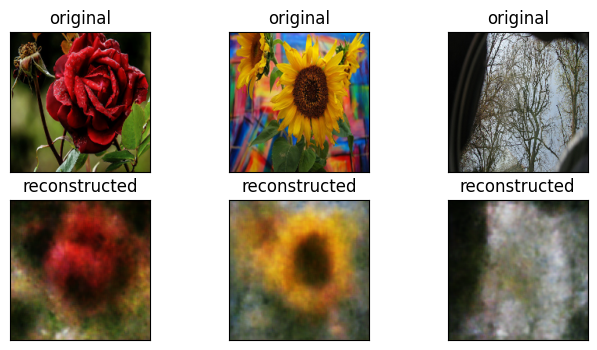


 Validation set:



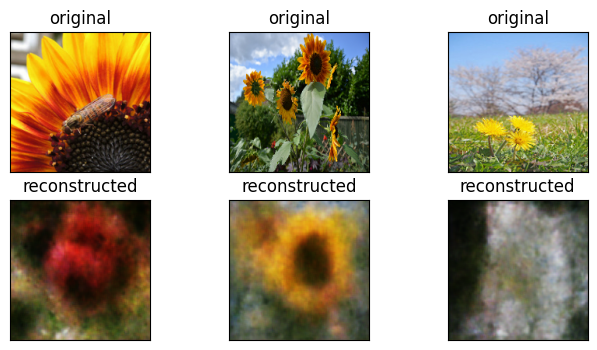

In [150]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_train_3imgs, 3)

## c) 
Sample 3 examples from each dataset split, the train and validation set, encoding the images using the Encoder, obtaining the intermediate representations. Using the GaussianNoise layer, introduce 5%, 10% and 20% noise to the representations. Finally, decode the representations using the Decoder and analyze the obtained images.

### 5%

In [153]:
encoded_train_3imgs = autoencoder.encoder(original_train_3imgs).numpy()
noise5_train = tf.keras.layers.GaussianNoise(0.05)(encoded_train_3imgs,training=True)
decoded_train_3imgs_n5 = autoencoder.decoder(noise5_train).numpy()

encoded_val_3imgs = autoencoder.encoder(original_val_3imgs).numpy()
noise5_val = tf.keras.layers.GaussianNoise(0.05)(encoded_val_3imgs,training=True)
decoded_val_3imgs_n5 = autoencoder.decoder(noise5_val).numpy()

Train set:



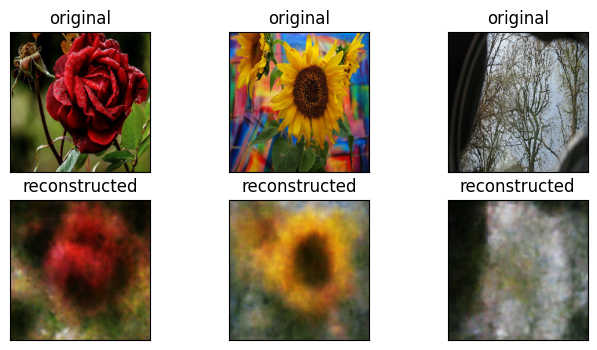


 Validation set:



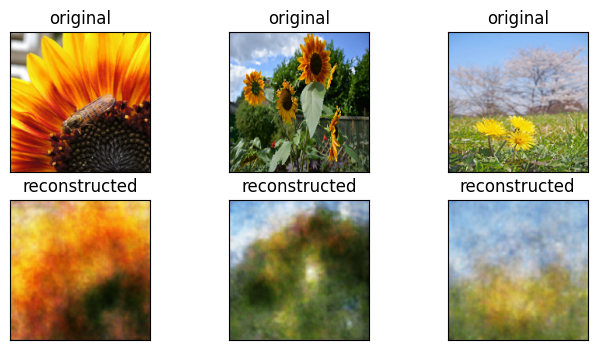

In [154]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs_n5, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_val_3imgs_n5, 3)

### 10%

In [155]:
encoded_train_3imgs = autoencoder.encoder(original_train_3imgs).numpy()
noise10_train = tf.keras.layers.GaussianNoise(0.1)(encoded_train_3imgs,training=True)
decoded_train_3imgs_n10 = autoencoder.decoder(noise10_train).numpy()

encoded_val_3imgs = autoencoder.encoder(original_val_3imgs).numpy()
noise10_val = tf.keras.layers.GaussianNoise(0.1)(encoded_val_3imgs,training=True)
decoded_val_3imgs_n10 = autoencoder.decoder(noise10_val).numpy()

Train set:



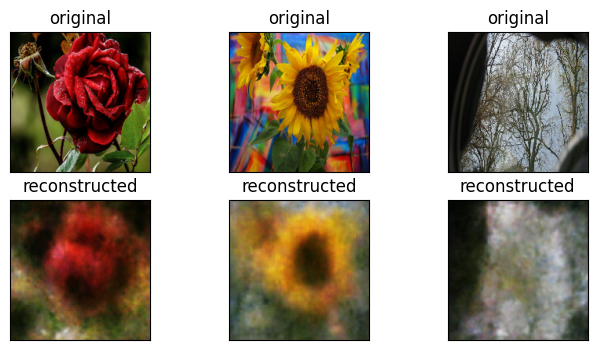


 Validation set:



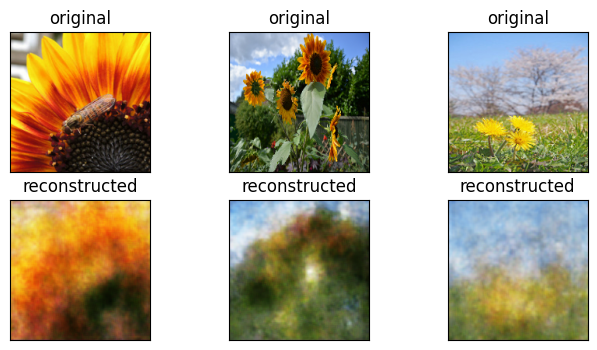

In [156]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs_n10, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_val_3imgs_n10, 3)

### 20%

In [157]:
encoded_train_3imgs = autoencoder.encoder(original_train_3imgs).numpy()
noise20_train = tf.keras.layers.GaussianNoise(0.2)(encoded_train_3imgs,training=True)
decoded_train_3imgs_n20 = autoencoder.decoder(noise20_train).numpy()

encoded_val_3imgs = autoencoder.encoder(original_val_3imgs).numpy()
noise20_val = tf.keras.layers.GaussianNoise(0.2)(encoded_val_3imgs,training=True)
decoded_val_3imgs_n20 = autoencoder.decoder(noise20_val).numpy()

Train set:



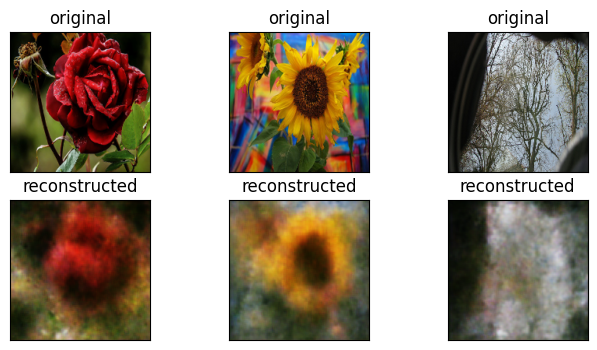


 Validation set:



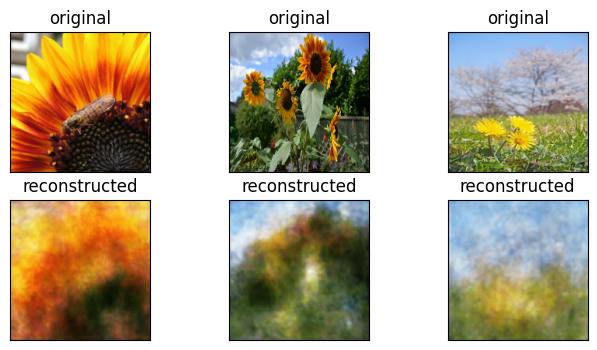

In [158]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs_n20, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_val_3imgs_n20, 3)

## d) 
Sample 3 examples from each dataset split, the train and validation set, and introduce 5%, 10% and 20% noise (GaussianNoise Layer) to the image pixels (input level). Run the autoencoder with these inputs and analyze the obtained images.

In [159]:
noise5_train = tf.keras.layers.GaussianNoise(0.05)(original_train_3imgs,training=True)
encoded_train_3imgs_n5 = autoencoder.encoder(noise5_train).numpy()
decoded_train_3imgs_n5 = autoencoder.decoder(encoded_train_3imgs_n5).numpy()

noise5_val = tf.keras.layers.GaussianNoise(0.05)(original_val_3imgs,training=True)
encoded_val_3imgs_n5 = autoencoder.encoder(noise5_val).numpy()
decoded_val_3imgs_n5 = autoencoder.decoder(encoded_val_3imgs_n5).numpy()

Train set:



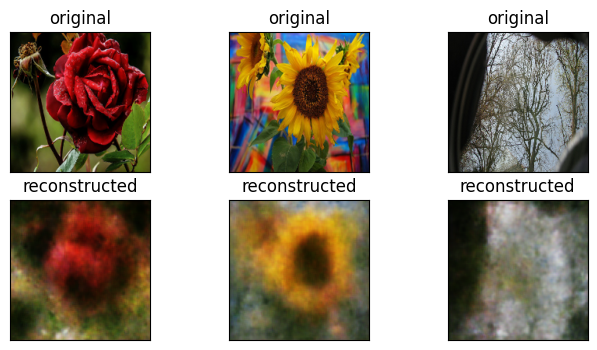


 Validation set:



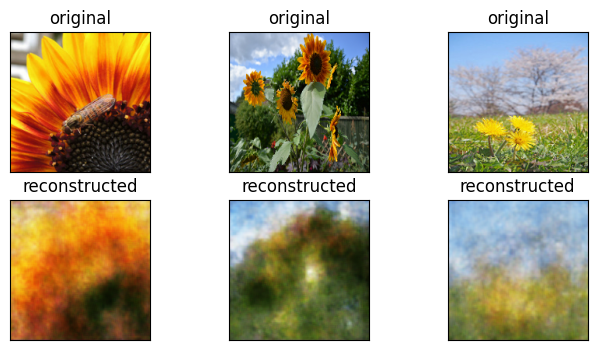

In [160]:
print("Train set:\n")
image_plot(original_train_3imgs, decoded_train_3imgs_n5, 3)

print("\n Validation set:\n")
image_plot(original_val_3imgs, decoded_val_3imgs_n5, 3)